In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path='/content/drive/MyDrive/Audio_Tagging_MLSP'
import numpy as np 
import os
import glob
import pandas as pd
import librosa
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from keras.preprocessing import image
from tensorflow.keras.models import load_model
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import accuracy_score, hamming_loss, multilabel_confusion_matrix, classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import ModelCheckpoint

In [ ]:
def to_multihot(eventroll):
    """
    Parameters
    ----------
    eventroll : np.array
        Eventroll matrix of shape=(11, 1000).
    
    Returns
    -------
    np.array
        A multihot vector of shape=(10,)
    """
    
    # findout active events:
    active_events = (eventroll.sum(axis=1) >= 0.5).astype('float')
    
    # remove silence class:
    return np.delete(active_events, 8)

In [ ]:
path='/content/drive/MyDrive/Audio_Tagging_MLSP'
X_train=np.load(os.path.join(path, "X_train.npy"))
X_test=np.load(os.path.join(path, "X_test.npy"))
Y_train=np.load(os.path.join(path, "Y_train.npy"))
Y_test=np.load(os.path.join(path, "Y_test.npy"))

In [ ]:
X_train=X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2], 1))
X_train.shape
X_test=X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2], 1))
X_test.shape

(2000, 64, 1000, 1)

In [ ]:
def macro_f1(y, y_hat, thresh=0.1):
    """Compute the macro F1-score on a batch of observations (average F1 across labels)
    
    Args:
        y (int32 Tensor): labels array of shape (BATCH_SIZE, N_LABELS)
        y_hat (float32 Tensor): probability matrix from forward propagation of shape (BATCH_SIZE, N_LABELS)
        thresh: probability value above which we predict positive
        
    Returns:
        macro_f1 (scalar Tensor): value of macro F1 for the batch
    """
    y_pred = tf.cast(tf.greater(y_hat, thresh), tf.float32)
    tp = tf.cast(tf.math.count_nonzero(y_pred * y, axis=0), tf.float32)
    fp = tf.cast(tf.math.count_nonzero(y_pred * (1 - y), axis=0), tf.float32)
    fn = tf.cast(tf.math.count_nonzero((1 - y_pred) * y, axis=0), tf.float32)
    f1 = 2*tp / (2*tp + fn + fp + 1e-16)
    macro_f1 = tf.reduce_mean(f1)
    return macro_f1

In [ ]:
class Attention():
    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')
        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)
        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)
        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight((input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]

        if self.bias:
            self.b = self.add_weight((input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None
        self.built = True

    def compute_mask(self, input, input_mask=None):
        return None

    def call(self, x, mask=None):
        features_dim = self.features_dim
        step_dim = self.step_dim

        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)),
                        K.reshape(self.W, (features_dim, 1))), (-1, step_dim))
        if self.bias:
            eij += self.b
        eij = K.tanh(eij)
        a = K.exp(eij)
        if mask is not None:
            a *= K.cast(mask, K.floatx())
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())
        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0],  self.features_dim


In [ ]:
def multi_label_classifier(input_shape):
    print(input_shape) 
#     inputs = tf.keras.Input(shape=input_shape)
    num_classes = 10 # categories of sound
    model = keras.models.Sequential()

    model.add(keras.layers.LSTM(128,input_shape = input_shape))
    # input layer
    model.add(keras.layers.Dropout(0.2)),
    
    # first hidden layer
    model.add(keras.layers.Dense(512, activation="relu")),
    
    # second hidden layer
    model.add(keras.layers.Dense(256, activation="relu")),
    
    # third hidden layer
    model.add(keras.layers.Dense(128, activation="relu"))

    # fourth hidden layer
    model.add(keras.layers.Dense(64, activation="relu"))

    # fifth hidden layer
    model.add(keras.layers.Dense(32, activation="relu"))

    model.add(keras.layers.ELU())
    model.add(keras.layers.Dropout(0.2))

    # output layer
    model.add(keras.layers.Dense(num_classes, activation='sigmoid')),
  
    model.compile(optimizer=keras.optimizers.Adam(1e-4), 
        loss='binary_crossentropy', # one-hot encoding for binary arrays
        metrics=['accuracy','AUC',macro_f1]) # provides better estimates of accuracy for one-hot labels
    return model

In [ ]:
path='/content/drive/MyDrive/Audio_Tagging_MLSP/RNN_model'
filepath=os.path.join(path, "./RNN_model_2.h5")
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath,
    monitor='macro_f1',
    mode='max',
    save_best_only=True,
    )

In [ ]:
from matplotlib import pyplot as plt
model = multi_label_classifier(input_shape=X_train.shape[1:3])
# model = tf.keras.models.load_model('/content/drive/MyDrive/Audio_Tagging_MLSP/NN_model/thresh_0.1_NN_model47.h5',custom_objects={"macro_f1":macro_f1})
# model.compile(loss='binary_crossentropy', optimizer='adam', metrics=["accuracy"])
model.summary()

(64, 1000)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 128)               578048    
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_6 (Dense)             (None, 512)               66048     
                                                                 
 dense_7 (Dense)             (None, 256)               131328    
                                                                 
 dense_8 (Dense)             (None, 128)               32896     
                                                                 
 dense_9 (Dense)             (None, 64)                8256      
                                                                 
 dense_10 (Dense)            (None, 32)    

In [ ]:
history=model.fit(X_train, Y_train, validation_data=(X_test, Y_test), batch_size=32, epochs=135, verbose = 2, callbacks=[model_checkpoint_callback])

Epoch 1/135
313/313 - 12s - loss: 0.4193 - accuracy: 0.1133 - auc: 0.7325 - macro_f1: 0.2961 - val_loss: 0.4618 - val_accuracy: 0.0480 - val_auc: 0.6574 - val_macro_f1: 0.2337 - 12s/epoch - 40ms/step
Epoch 2/135
313/313 - 4s - loss: 0.3892 - accuracy: 0.1125 - auc: 0.7592 - macro_f1: 0.3091 - val_loss: 0.4531 - val_accuracy: 0.0480 - val_auc: 0.6929 - val_macro_f1: 0.2294 - 4s/epoch - 12ms/step
Epoch 3/135
313/313 - 4s - loss: 0.3825 - accuracy: 0.1124 - auc: 0.7768 - macro_f1: 0.3233 - val_loss: 0.4561 - val_accuracy: 0.0480 - val_auc: 0.6935 - val_macro_f1: 0.2273 - 4s/epoch - 12ms/step
Epoch 4/135
313/313 - 4s - loss: 0.3769 - accuracy: 0.1126 - auc: 0.7889 - macro_f1: 0.3312 - val_loss: 0.4428 - val_accuracy: 0.0480 - val_auc: 0.7249 - val_macro_f1: 0.2292 - 4s/epoch - 12ms/step
Epoch 5/135
313/313 - 5s - loss: 0.3713 - accuracy: 0.1125 - auc: 0.8027 - macro_f1: 0.3424 - val_loss: 0.4455 - val_accuracy: 0.0480 - val_auc: 0.7194 - val_macro_f1: 0.2296 - 5s/epoch - 16ms/step
Epoch 6/

In [ ]:
def apply_threshold_in_predictions(Y_pred, threshold):
  for arr in Y_pred:
    j=0
    for _ in arr:
      if(_>=threshold):
        arr[j] = 1
      else:
        arr[j] = 0
      j=j+1
  
  return Y_pred

In [ ]:
check_model = tf.keras.models.load_model('/content/drive/MyDrive/Audio_Tagging_MLSP/RNN_model/RNN_model.h5',custom_objects={"macro_f1":macro_f1})

In [ ]:
Y_pred = check_model.predict(X_test)

63/63 [==============================] - 1s 8ms/step


In [ ]:
from sklearn.metrics import classification_report
print(apply_threshold_in_predictions(Y_pred, 0.1))
print(classification_report(Y_test, Y_pred))

[[0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 1. 0.]
 ...
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 1. ... 0. 1. 0.]]
              precision    recall  f1-score   support

           0       0.22      0.19      0.20       392
           1       0.41      0.13      0.19       436
           2       0.22      0.18      0.20       274
           3       0.24      0.20      0.22       444
           4       0.22      0.18      0.19       306
           5       0.26      0.14      0.18       221
           6       0.27      0.32      0.29       130
           7       0.14      0.09      0.11       143
           8       0.63      0.91      0.75      1246
           9       0.08      0.03      0.04       151

   micro avg       0.44      0.41      0.43      3743
   macro avg       0.27      0.24      0.24      3743
weighted avg       0.38      0.41      0.38      3743
 samples avg       0.45      0.38      0.39      3743



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


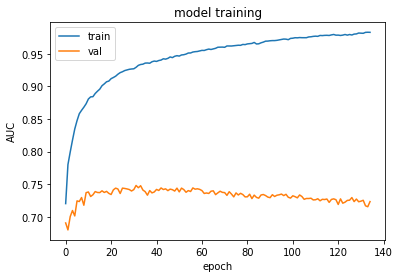

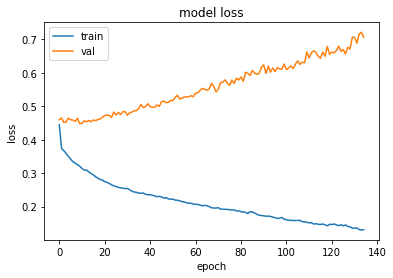

In [ ]:
from matplotlib import pyplot as plt
model.metrics_names
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('model training')
plt.ylabel('AUC')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()